#Covid-19 Detection

In [2]:
from google.colab import drive
drive.mount("gdrive")

## Import the necessary libraries

In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import cv2
import shutil
import os

#ML libraries and utils
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.model_selection import train_test_split

import tensorflow as tf

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


## Dataset

In [4]:
metadata = pd.read_csv("/content/gdrive/My Drive/DataAnalysis/Covid19/Chest_xray_Corona_Metadata.csv")
summary = pd.read_csv("/content/gdrive/My Drive/DataAnalysis/Covid19/Chest_xray_Corona_dataset_Summary.csv")

The dataset is a little bit complex and needs to be cleared out before getting started to analyze.*metadata* dataframe contains the X-ray file names.Each instance of a X-ray is also labeled stating whether the patient is healthy or 
a person with pneumonia.

*summary* dataframe only contains information regarding on the distribution of the categorical variables among the columns.

In [5]:
metadata.head()

,Unnamed: 0,X_ray_image_name,Label,Dataset_type,Label_2_Virus_category,Label_1_Virus_category
0,0,IM-0128-0001.jpeg,Normal,TRAIN,NaN,NaN
1,1,IM-0127-0001.jpeg,Normal,TRAIN,NaN,NaN
2,2,IM-0125-0001.jpeg,Normal,TRAIN,NaN,NaN
3,3,IM-0122-0001.jpeg,Normal,TRAIN,NaN,NaN
4,4,IM-0119-0001.jpeg,Normal,TRAIN,NaN,NaN


In [6]:
metadata.shape

(5910, 6)

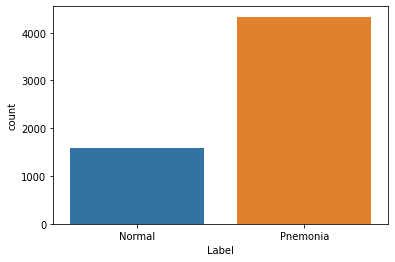

In [7]:
sns.countplot(metadata.Label)

In [8]:
summary.head()

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4


In [9]:
summary

,Unnamed: 0,Label,Label_1_Virus_category,Label_2_Virus_category,Image_Count
0,0,Normal,NaN,NaN,1576
1,1,Pnemonia,Stress-Smoking,ARDS,2
2,2,Pnemonia,Virus,NaN,1493
3,3,Pnemonia,Virus,COVID-19,58
4,4,Pnemonia,Virus,SARS,4
5,5,Pnemonia,bacteria,NaN,2772
6,6,Pnemonia,bacteria,Streptococcus,5


In [10]:
metadata.Label_1_Virus_category.fillna("healthy",inplace=True)

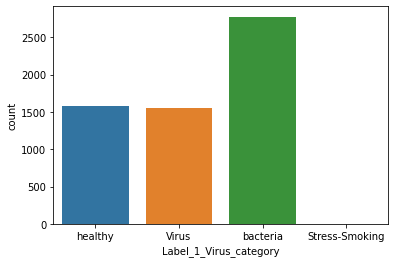

In [11]:
sns.countplot(metadata.Label_1_Virus_category)

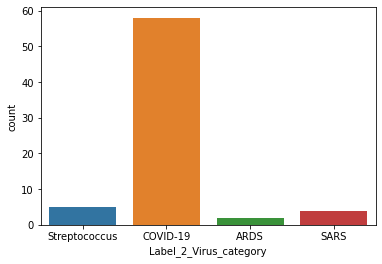

In [12]:
sns.countplot(metadata.Label_2_Virus_category)

In [13]:
for i, row in metadata.iterrows():
  if pd.isnull(row.Label_2_Virus_category) and row.Label_1_Virus_category=="bacteria":
    ifor_val = "unknown_bacteria"
    metadata.at[i,'Label_2_Virus_category']=ifor_val
  elif pd.isnull(row.Label_2_Virus_category) and row.Label_1_Virus_category=="Virus":
    ifor_val="unknown_virus"
    metadata.at[i,'Label_2_Virus_category']=ifor_val
  elif pd.isnull(row.Label_2_Virus_category) and row.Label_1_Virus_category=="healthy":
    ifor_val="healthy"
    metadata.at[i,'Label_2_Virus_category']=ifor_val

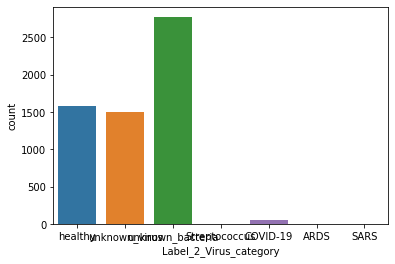

In [14]:
sns.countplot(metadata.Label_2_Virus_category)

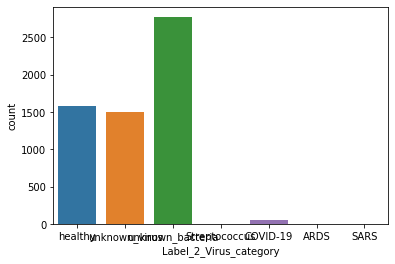

In [15]:
sns.countplot(metadata.Label_2_Virus_category)

## X-ray metadata

## Train-Test Generator

In [16]:
from keras.preprocessing.image import ImageDataGenerator,load_img,img_to_array
from shutil import rmtree,copy2
import os 

###Traini Directory

In [17]:
train_df = metadata[metadata.Dataset_type=="TRAIN"]

In [18]:
train_df.shape

(5286, 6)

In [19]:
train_df.Label.value_counts()

Pnemonia    3944
Normal      1342
Name: Label, dtype: int64

In [21]:
os.makedirs('/content/train/',exist_ok=True)
for class_ in train_df.Label.unique():
  os.makedirs('train/'+str(class_)+'/',exist_ok=True)

In [22]:
y_train = train_df.Label

In [23]:
for image,type_  in zip(train_df.X_ray_image_name	, y_train):
    copy2(os.path.join("/content/gdrive/My Drive/DataAnalysis/Covid19/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/train",image), 'train/'+type_)

### Test Directory

In [24]:
test_df = metadata[metadata.Dataset_type=="TEST"]

In [25]:
test_df.shape

(624, 6)

In [26]:
y_test = test_df.Label

In [27]:
test_df.Label.value_counts()

Pnemonia    390
Normal      234
Name: Label, dtype: int64

In [28]:
os.makedirs('/content/test/',exist_ok=True)
for class_ in test_df.Label.unique():
  os.makedirs('test/'+str(class_)+'/',exist_ok=True)

In [29]:
for image,type_  in zip(test_df.X_ray_image_name	, y_test):
    copy2(os.path.join("/content/gdrive/My Drive/DataAnalysis/Covid19/Coronahack-Chest-XRay-Dataset/Coronahack-Chest-XRay-Dataset/test",image), 'test/'+type_)

In [ ]:
#train_df = train_df[(train_df.Label_2_Virus_category=="healthy")|(train_df.Label_2_Virus_category=="COVID-19") ] 

### Data Generators

In [32]:
train_data_gen = ImageDataGenerator(
    rescale=1./255,
)
train_generator = train_data_gen.flow_from_directory(
    "/content/train",
    batch_size=32,
    class_mode="binary"
)

valid_data_gen = ImageDataGenerator(
    rescale=1./255,
)

valid_generator = train_data_gen.flow_from_directory(
    "/content/test",
    batch_size=32,
    class_mode="binary"
)

Found 5286 images belonging to 2 classes.
Found 624 images belonging to 2 classes.


## DenseNet-121

In [34]:
dense_net121 = tf.keras.applications.DenseNet121(
    include_top=False, weights='imagenet',input_shape= (256,256,3)
)
for layer in dense_net121.layers:
    layer.trainable = False

In [35]:
model=tf.keras.Sequential()
model.add(dense_net121)
model.add(tf.keras.layers.MaxPooling2D(name="MaxPool_"))
model.add(tf.keras.layers.Dropout(0.2, name="dropout_out"))
model.add(tf.keras.layers.Flatten())
model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

In [36]:
model.compile(loss='binary_crossentropy',
              optimizer="adam",
              metrics=['accuracy'])

In [39]:
history = model.fit_generator(train_generator,
                              epochs=5,
                              validation_data=valid_generator
                              )

Epoch 1/5
166/166 [==============================] - 936s 6s/step - loss: 0.1935 - accuracy: 0.9327 - val_loss: 0.5502 - val_accuracy: 0.8413
Epoch 2/5
166/166 [==============================] - 934s 6s/step - loss: 0.0686 - accuracy: 0.9729 - val_loss: 0.4880 - val_accuracy: 0.8766
Epoch 3/5
166/166 [==============================] - 935s 6s/step - loss: 0.0485 - accuracy: 0.9803 - val_loss: 0.8185 - val_accuracy: 0.8173
Epoch 4/5
166/166 [==============================] - 939s 6s/step - loss: 0.0423 - accuracy: 0.9837 - val_loss: 1.6378 - val_accuracy: 0.7404
Epoch 5/5
166/166 [==============================] - 931s 6s/step - loss: 0.0324 - accuracy: 0.9885 - val_loss: 0.8621 - val_accuracy: 0.8413


In [42]:
import plotly.graph_objects as go
fig = go.Figure()


fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['accuracy'],
                         line=dict(color='orange', width=2, dash='dash'), name='accuracy'))
fig.add_trace(go.Scatter(x=list(range(1,11)), y=history.history['val_accuracy'],
                         line=dict(color='green', width=2), name='validation accuracy'))

fig.update_layout(title_text='Plot of evaluation metrics', font_size=15, xaxis_title='Epochs')
fig.show()